In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor,XGBRFRegressor

from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV

In [3]:
RMSLE = 'neg_mean_squared_log_error'
NMS = 'neg_mean_squared_error'

In [4]:
def load_data():
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    return [train, test]

In [5]:
load_data()[0].columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [6]:
def translate_log(X):
    for col in ['casual','registered','count']:
        X['%s_log' % col] = np.log(X[col] + 1)
    return X

In [7]:
X_train,X_test = load_data()

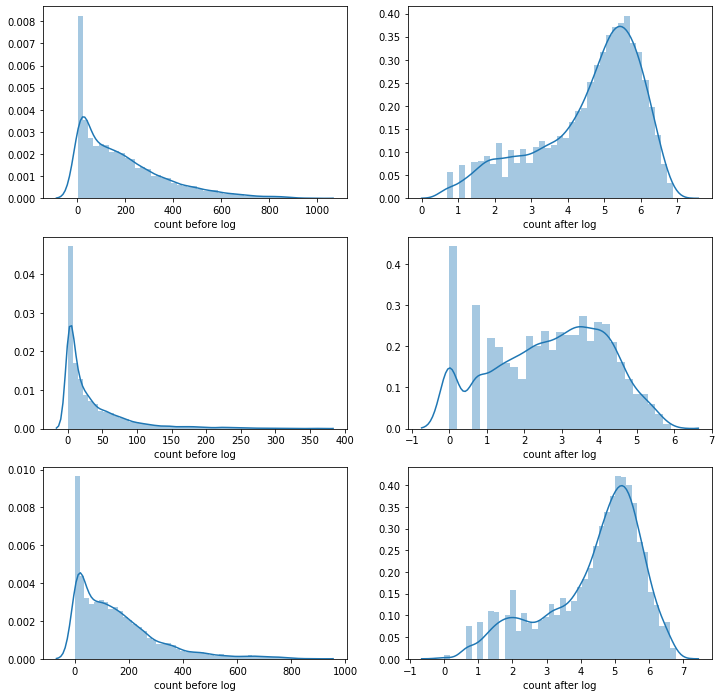

In [8]:
def plot_dist():
    # count
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(321)
    sns.distplot(X_train['count'],ax=ax)
    ax.set_xlabel('count before log')
    ax = plt.subplot(322)
    sns.distplot(np.log(X_train['count'] + 1),ax=ax)
    ax.set_xlabel('count after log')
    
    # casual
    ax = plt.subplot(323)
    sns.distplot(X_train['casual'],ax=ax)
    ax.set_xlabel('count before log')
    ax = plt.subplot(324)
    sns.distplot(np.log(X_train['casual'] + 1),ax=ax)
    ax.set_xlabel('count after log')

    # register
    ax = plt.subplot(325)
    sns.distplot(X_train['registered'],ax=ax)
    ax.set_xlabel('count before log')
    ax = plt.subplot(326)
    sns.distplot(np.log(X_train['registered'] + 1),ax=ax)
    ax.set_xlabel('count after log')

plot_dist()

In [9]:
def translate_datetime(X):
    X_ = X.copy()
    X_date = pd.DatetimeIndex(X['datetime'])
    X_['year'] = X_date.year
    X_['month'] = X_date.month
    X_['hour'] = X_date.hour
    X_['dayofweek'] = X_date.dayofweek
    return X_

In [10]:
X_train = translate_datetime(X_train)
X_test = translate_datetime(X_test)

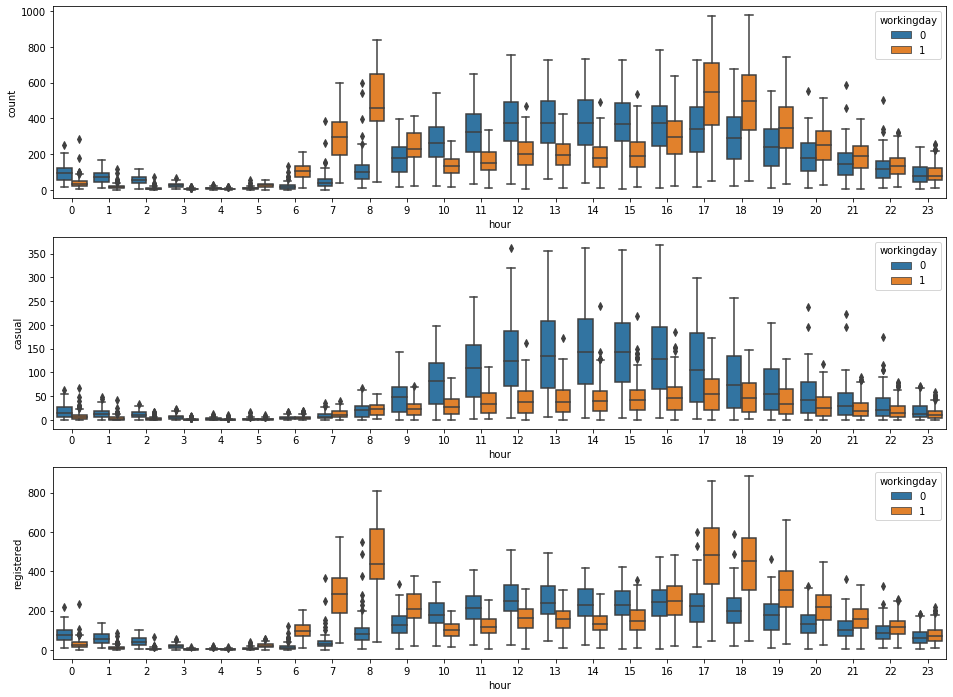

In [11]:
def plot_hour_hue_workingday():
    fig = plt.figure(figsize=(16,12))
    axes = fig.subplots(3,1)
    sns.boxplot(x = 'hour' ,y = 'count' ,hue = 'workingday' ,data = X_train ,ax = axes[0])
    sns.boxplot(x = 'hour' ,y = 'casual' ,hue = 'workingday' ,data = X_train ,ax = axes[1])
    sns.boxplot(x = 'hour' ,y = 'registered' ,hue = 'workingday' ,data = X_train ,ax = axes[2])
plot_hour_hue_workingday()

In [12]:
def new_feature_year_season(train ,test):
    for X in [train,test]:
        X['year_season'] = X['year'] + 0.1 * X['season']
        
    by_season = train.groupby('year_season')[['count']].median()
    by_season.columns = ['count_year_season']
    
    train = train.join(by_season, on='year_season')
    test = test.join(by_season,on='year_season')
    
    return [train,test]

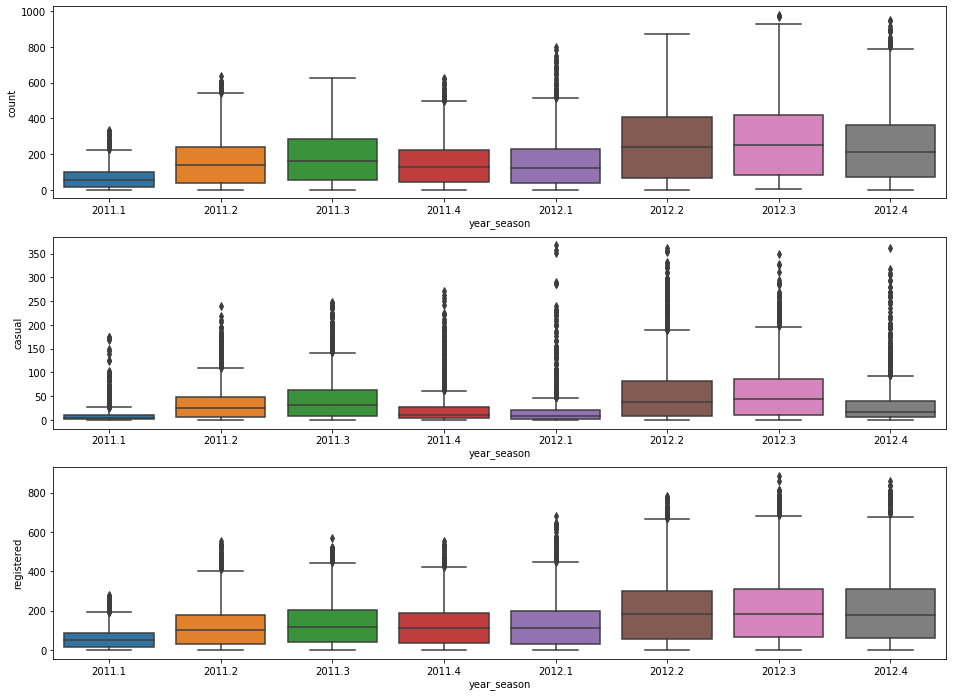

In [13]:
def plot_year_season(X):
    X['year_season'] = X['year'] + 0.1 * X['season']
    fig = plt.figure(figsize=(16,12))
    axes = fig.subplots(3,1)
    sns.boxplot(x = 'year_season' ,y = 'count' ,data = X ,ax = axes[0])
    sns.boxplot(x = 'year_season' ,y = 'casual' ,data = X ,ax = axes[1])
    sns.boxplot(x = 'year_season' ,y = 'registered' ,data = X ,ax = axes[2])
    
plot_year_season(X_train)

In [14]:
def drop_columns(X,columns):
    return X.drop(columns = columns)

In [15]:
def new_feature_workingday_hour(X):
    X['hour_workingday_casual'] = X[['workingday','hour']].apply(
        lambda x : int(10 <= x['hour'] <= 19)
    ,axis=1)
    X['hour_workingday_registered'] = X[['workingday','hour']].apply(
        lambda x : int(
            (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18))
            or (x['workingday'] == 0 and 10 <= x['hour'] <= 19 )
        )
    ,axis=1)
    return X

In [16]:
def get_data():
    X_train,X_test = load_data()
    
    # date transform
    X_train = translate_datetime(X_train)
    X_test = translate_datetime(X_test)
    
    # log transform
    X_train = translate_log(X_train)
    
    # y_train
    y_train_count = X_train['count']
    y_train_casual = X_train['casual']
    y_train_registered = X_train['registered']
    
    # new features workingday hour
    for X in [X_train ,X_test]:
        X = new_feature_workingday_hour(X)
    # new features year_season count_season
    X_train,X_test = new_feature_year_season(X_train,X_test)
    
    # submission
    X_test['count'] = -1
    submissions = X_test[['datetime','count']]
    
    # drop features
    col_train = ['datetime','count','casual','registered']
    col_test = ['datetime','count']
    X_train = drop_columns(X_train,col_train)
    X_test = drop_columns(X_test,col_test)
    
    # submissions
    return X_train ,(y_train_count,y_train_casual,y_train_registered) ,X_test ,submissions

X_train ,y_trains, X_test ,submissions = get_data()
submissions.set_index('datetime',inplace=True)

In [17]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,casual_log,registered_log,count_log,hour_workingday_casual,hour_workingday_registered,year_season,count_year_season
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,0,5,1.386294,2.639057,2.833213,0,0,2011.1,57
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5,2.197225,3.496508,3.713572,0,0,2011.1,57
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,2,5,1.791759,3.332205,3.496508,0,0,2011.1,57
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,3,5,1.386294,2.397895,2.639057,0,0,2011.1,57
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,4,5,0.000000,0.693147,0.693147,0,0,2011.1,57


In [18]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek',
       'casual_log', 'registered_log', 'count_log', 'hour_workingday_casual',
       'hour_workingday_registered', 'year_season', 'count_year_season'],
      dtype='object')

In [19]:
def plot_cv(param, bestreg, variable,title):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(param[variable],bestreg.cv_results_['mean_test_score'],'o-')
    plt.xlabel(variable)
    plt.ylabel("score mean")
    plt.subplot(122)
    plt.plot(param[variable],bestreg.cv_results_['std_test_score'],'o-')
    plt.xlabel(variable)
    plt.ylabel("score std")
    plt.tight_layout()
    plt.title(title)
    plt.show()

def plot_nestimators_figure():
    X_train,_,_,_ = get_data()
    year_month = X_train['year'] * 100 + X_train['month']
    kf = StratifiedKFold(n_splits=5,shuffle=True) # 按比例划分

    param = {"n_estimators": [50, 100, 150
                              , 200, 250, 300, 350
                              , 400, 450, 500, 600, 700, 800, 900
                              , 1000]}
    # casual
    best_reg = GridSearchCV(GradientBoostingRegressor(),param_grid=param
                            ,cv=kf.split(X_train,year_month),scoring=NMS)
    best_reg.fit(X_train,X_train['casual_log'])
    print(best_reg.best_params_)
    plot_cv(param,best_reg,'n_estimators')
    
    # registered 
    best_reg = GridSearchCV(GradientBoostingRegressor(),param_grid=param
                            ,cv=kf.split(X_train,year_month),scoring=NMS)
    best_reg.fit(X_train,X_train['registered_log'])
    print(best_reg.best_params_)
    plot_cv(param,best_reg,'n_estimators')
    
#plot_nestimators_figure()

In [20]:
def plot_min_samples_split_figure():
    X_train ,_ ,_ ,_ = get_data()
    year_month = X_train['year'] * 100 + X_train['month']
    kf = StratifiedKFold(n_splits=5,shuffle=True) # 按比例划分
    
    param = {"min_samples_leaf": np.arange(1, 10, 1)}

    # casual
    best_reg = GridSearchCV(GradientBoostingRegressor(),param_grid=param
                            ,cv=kf.split(X_train,year_month),scoring=NMS)
    best_reg.fit(X_train,X_train['casual_log'])
    print(best_reg.best_params_)
    plot_cv(param ,best_reg ,'min_samples_leaf')
    
    # registered 
    best_reg = GridSearchCV(GradientBoostingRegressor(),param_grid=param
                            ,cv=kf.split(X_train,year_month),scoring=NMS)
    best_reg.fit(X_train,X_train['registered_log'])
    print(best_reg.best_params_)
    plot_cv(param ,best_reg ,'min_samples_leaf')
    
#plot_min_samples_split_figure()

{'n_estimators': 600}


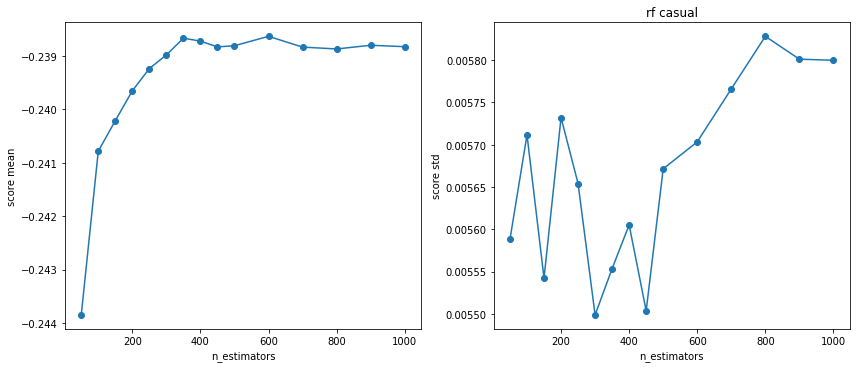

{'n_estimators': 900}


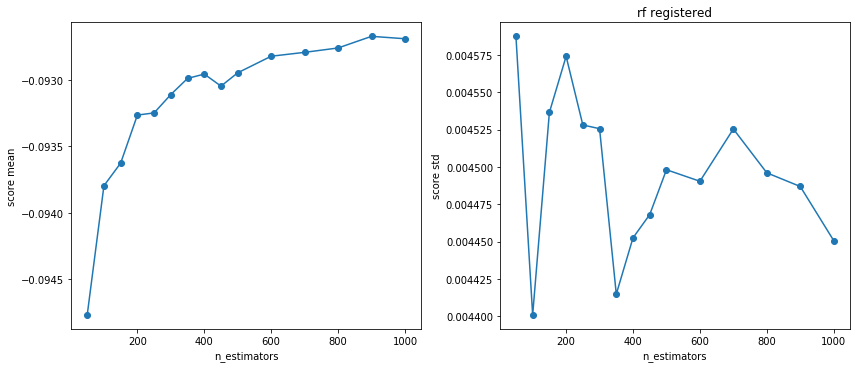

{'min_samples_leaf': 2}


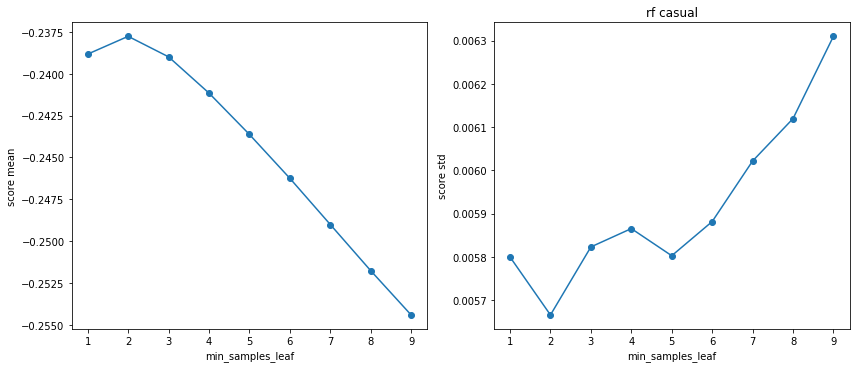

{'min_samples_leaf': 2}


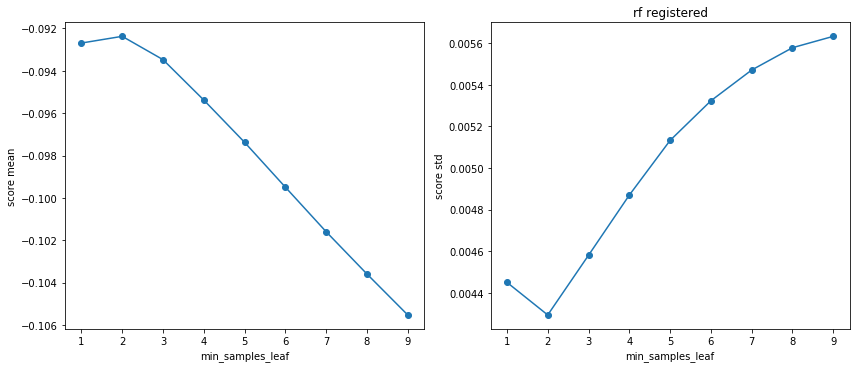

In [21]:
def plot_rf():
    train ,_ ,_ ,_ = get_data()

    year_month = train['year'] * 100 + train['month']
    
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    common_columns = [
    'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')
    
    # rf n_estimators for casual and registered
    reg = RandomForestRegressor(random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[casual_columns], train['casual_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'rf casual')

    reg = RandomForestRegressor(random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[registered_columns], train['registered_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'rf registered')
    
    # rf tune the min_sample_split
    reg = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
    param = {"min_samples_leaf": np.arange(1, 10, 1)}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[casual_columns], train['casual_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "min_samples_leaf",'rf casual')

    reg = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
    param = {"min_samples_leaf": np.arange(1, 10, 1)}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[registered_columns], train['registered_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "min_samples_leaf",'rf registered')
    
    
plot_rf()

{'n_estimators': 1000}


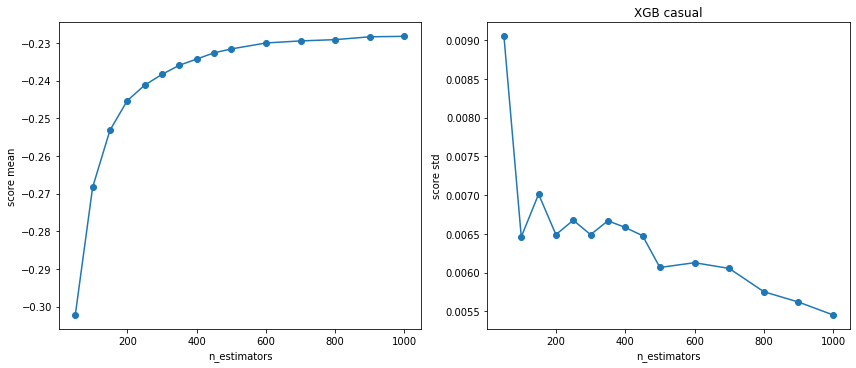

{'n_estimators': 1000}


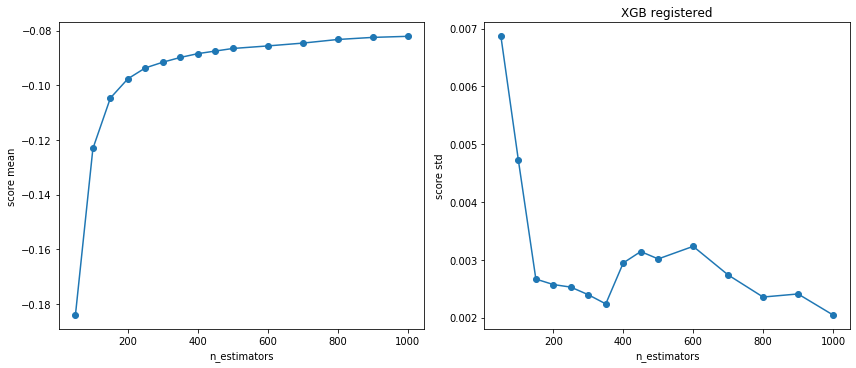

{'n_estimators': 200}


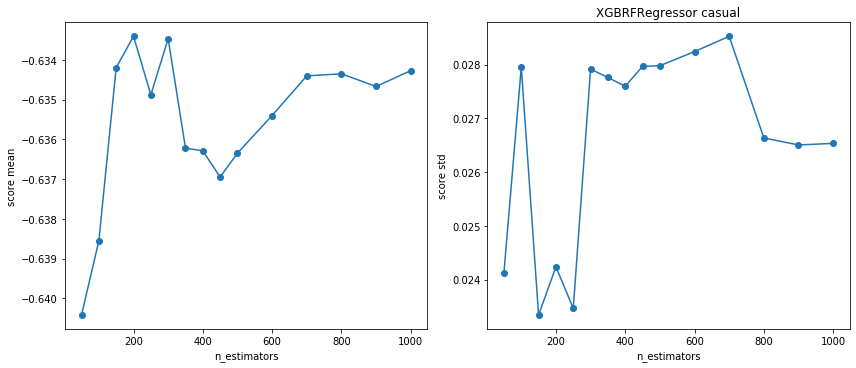

{'n_estimators': 50}


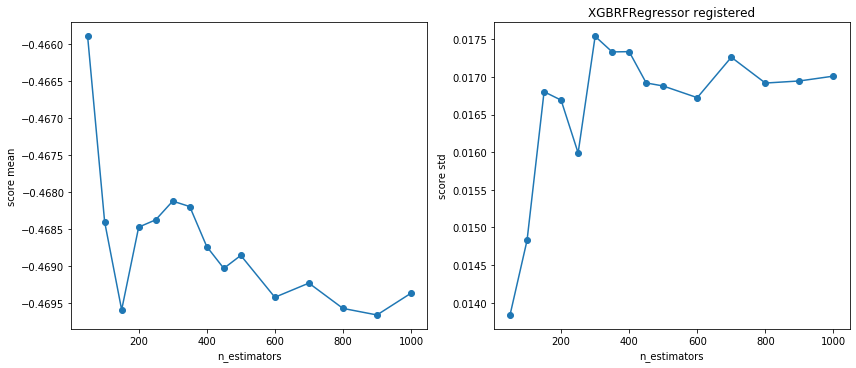

In [22]:
def plot_xg_reg():
    train ,_ ,_ ,_ = get_data()

    year_month = train['year'] * 100 + train['month']
    
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    common_columns = [
        'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')
    
    # xgb n_estimators for casual and registered
    reg = XGBRegressor(objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[casual_columns], train['casual_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'XGB casual')
    
    reg = XGBRegressor(objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[registered_columns], train['registered_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'XGB registered')
    
    
    # xgbrf n_estimators for casual and registered
    reg = XGBRFRegressor(objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[casual_columns], train['casual_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'XGBRFRegressor casual')
    
    reg = XGBRFRegressor(objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[registered_columns], train['registered_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "n_estimators",'XGBRFRegressor registered')
    '''
    # xgb gamma tune
    reg = XGBRegressor(n_estimators=1000,objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"gamma": np.linspace(1, 10, 20)}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[casual_columns], train['casual_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "gamma")

    reg = XGBRFRegressor(n_estimators=50,objective='reg:squarederror',random_state=0, n_jobs=-1)
    param = {"gamma": np.linspace(1, 10, 20)}
    bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring=NMS)
    bestreg.fit(train[registered_columns], train['registered_log'])
    print(bestreg.best_params_)
    plot_cv(param, bestreg, "gamma")
    '''
    # xgbrf gamma tune
    
    
plot_xg_reg()

In [23]:
def RMLSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log(y_true + 1) - np.log(y_pred + 1))))

In [24]:
def pred_cv_xgb():
    train,y_trains,_,_ = get_data()
    y_train_count,y_trains_casual,y_trains_registered = y_trains[0],y_trains[1],y_trains[2]
    year_month = train['year'] * 100 + train['month']
    common_columns = [
        'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
    results1, results2 = [], []
    results3, results4, results5, results6 = [], [], [], []
    
    for train_ind, test_ind in kf.split(train, year_month):
        cur_train = train.iloc[train_ind,:]
        cur_test = train.iloc[test_ind,:]
        y_train_test = y_train_count[test_ind]
        
        # XGBREG 
        # casual
        reg = XGBRegressor(n_estimators=1000, gamma=1, random_state=0,n_jobs=-1)
        reg.fit(cur_train[casual_columns], cur_train['casual_log'])
        pred_casual = reg.predict(cur_test[casual_columns])
        pred_casual = np.exp(pred_casual) - 1
        pred_casual[pred_casual < 0] = 0
        
        # registered
        reg = XGBRegressor(n_estimators=1000, gamma=1, random_state=0,n_jobs=-1)
        reg.fit(cur_train[registered_columns], cur_train['registered_log'])
        pred_registered = reg.predict(cur_test[registered_columns])
        pred_registered = np.exp(pred_registered) - 1
        pred_registered[pred_registered < 0] = 0
        
        pred1 = pred_casual + pred_registered
        results1.append(RMLSE(y_train_test, pred1))

        # XGBRFREG
        # casual
        reg = XGBRFRegressor(n_estimators=50, gamma=1, random_state=0, n_jobs=-1)
        reg.fit(cur_train[casual_columns], cur_train['casual_log'])
        pred_casual = reg.predict(cur_test[casual_columns])
        pred_casual = np.exp(pred_casual) - 1
        pred_casual[pred_casual < 0] = 0

        # registered
        reg = XGBRFRegressor(n_estimators=50, gamma=1, random_state=0, n_jobs=-1)
        reg.fit(cur_train[registered_columns], cur_train['registered_log'])
        pred_registered = reg.predict(cur_test[registered_columns])
        pred_registered = np.exp(pred_registered) - 1
        pred_registered[pred_registered < 0] = 0
        pred2 = pred_casual + pred_registered
        results2.append(RMLSE(y_train_test, pred2))

        # see the two modules together
        pred_55 = 0.5 * pred1 + 0.5 * pred2
        results3.append(RMLSE(y_train_test, pred_55))
        pred_64 = 0.6 * pred1 + 0.4 * pred2
        results4.append(RMLSE(y_train_test, pred_64))
        pred_73 = 0.7 * pred1 + 0.3 * pred2
        results5.append(RMLSE(y_train_test, pred_73))
        pred_82 = 0.8 * pred1 + 0.2 * pred2
        results6.append(RMLSE(y_train_test, pred_82))

    print("XGB", np.mean(results1))
    print("XGBRF", np.mean(results2))
    print("0.5 * XGB + 0.5 * XGBRF", np.mean(results3))
    print("0.6 * XGB + 0.4 * XGBRF", np.mean(results4))
    print("0.7 * XGB + 0.3 * XGBRF", np.mean(results5))
    print("0.8 * XGB + 0.2 * XGBRF", np.mean(results6))
    
    return pred1,pred2,pred_55,pred_64,pred_73,pred_82


In [25]:
def pred_cv():
    train,y_trains,_,_ = get_data()
    y_train_count,y_trains_casual,y_trains_registered = y_trains[0],y_trains[1],y_trains[2]
    year_month = train['year'] * 100 + train['month']
    common_columns = [
       'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
    results1, results2 = [], []
    results3, results4, results5, results6 = [], [], [], []
    
    for train_ind, test_ind in kf.split(train, year_month):
        cur_train = train.iloc[train_ind,:]
        cur_test = train.iloc[test_ind,:]
        y_train_test = y_train_count[test_ind]
        
        # GBR reg 
        # casual
        reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
        reg.fit(cur_train[casual_columns], cur_train['casual_log'])
        pred_casual = reg.predict(cur_test[casual_columns])
        pred_casual = np.exp(pred_casual) - 1
        pred_casual[pred_casual < 0] = 0
        
        # registered
        reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
        reg.fit(cur_train[registered_columns], cur_train['registered_log'])
        pred_registered = reg.predict(cur_test[registered_columns])
        pred_registered = np.exp(pred_registered) - 1
        pred_registered[pred_registered < 0] = 0
        
        pred1 = pred_casual + pred_registered
        results1.append(RMLSE(y_train_test, pred1))

        # RF
        # casual
        reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
        reg.fit(cur_train[casual_columns], cur_train['casual_log'])
        pred_casual = reg.predict(cur_test[casual_columns])
        pred_casual = np.exp(pred_casual) - 1
        pred_casual[pred_casual < 0] = 0

        # registered
        reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
        reg.fit(cur_train[registered_columns], cur_train['registered_log'])
        pred_registered = reg.predict(cur_test[registered_columns])
        pred_registered = np.exp(pred_registered) - 1
        pred_registered[pred_registered < 0] = 0
        pred2 = pred_casual + pred_registered
        results2.append(RMLSE(y_train_test, pred2))

        # see the two modules together
        pred_55 = 0.5 * pred1 + 0.5 * pred2
        results3.append(RMLSE(y_train_test, pred_55))
        pred_64 = 0.6 * pred1 + 0.4 * pred2
        results4.append(RMLSE(y_train_test, pred_64))
        pred_73 = 0.7 * pred1 + 0.3 * pred2
        results5.append(RMLSE(y_train_test, pred_73))
        pred_82 = 0.8 * pred1 + 0.2 * pred2
        results6.append(RMLSE(y_train_test, pred_82))

    print("GBDT", np.mean(results1))
    print("RF", np.mean(results2))
    print("0.5 * GBDT + 0.5 * RF", np.mean(results3))
    print("0.6 * GBDT + 0.4 * RF", np.mean(results4))
    print("0.7 * GBDT + 0.3 * RF", np.mean(results5))
    print("0.8 * GBDT + 0.2 * RF", np.mean(results6))
    
    return pred1,pred2,pred_55,pred_64,pred_73,pred_82

pred1,pred2,pred_55,pred_64,pred_73,pred_82 = pred_cv()

GBDT 0.286512437363658
RF 0.29970458582377346
0.5 * GBDT + 0.5 * RF 0.28145187225824536
0.6 * GBDT + 0.4 * RF 0.28044827488996177
0.7 * GBDT + 0.3 * RF 0.2803899359366205
0.8 * GBDT + 0.2 * RF 0.28132778311470075


In [26]:
def get_submissions():
    
    train,y_trains,test,submissions = get_data()
    y_train_count,y_trains_casual,y_trains_registered = y_trains[0],y_trains[1],y_trains[2]
    common_columns = [
        'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')

    # GBR reg 
    # casual
    reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
    reg.fit(train[casual_columns], train['casual_log'])
    pred_casual = reg.predict(test[casual_columns])
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0

    # registered
    reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
    reg.fit(train[registered_columns], train['registered_log'])
    pred_registered = reg.predict(test[registered_columns])
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0

    pred1 = pred_casual + pred_registered

    # RF
    # casual
    reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
    reg.fit(train[casual_columns], train['casual_log'])
    pred_casual = reg.predict(test[casual_columns])
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0

    # registered
    reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
    reg.fit(train[registered_columns], train['registered_log'])
    pred_registered = reg.predict(test[registered_columns])
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0
    
    pred2 = pred_casual + pred_registered

    # see the two modules together
    pred_55 = 0.5 * pred1 + 0.5 * pred2
    pred_64 = 0.6 * pred1 + 0.4 * pred2
    pred_46 = 0.4 * pred1 + 0.6 * pred2
    pred_37 = 0.3 * pred1 + 0.7 * pred2

    submissions.set_index('datetime',inplace=True)
    
    submissions_gbt = submissions.copy()
    submissions_gbt['count'] = pred1.astype('int32')
    
    submissions_rf = submissions.copy()
    submissions_rf['count'] = pred2.astype('int32')
    
    submissions_55 = submissions.copy()
    submissions_55['count'] = pred_55.astype('int32')
    
    submissions_64 = submissions.copy()
    submissions_64['count'] = pred_64.astype('int32')
    
    submissions_46 = submissions.copy()
    submissions_46['count'] = pred_46.astype('int32')
    
    submissions_37 = submissions.copy()
    submissions_37['count'] = pred_37.astype('int32')
    
    return submissions_gbt,submissions_rf,submissions_55,submissions_64, submissions_46,submissions_37

#submissions_gbt,submissions_rf,submissions_55,submissions_64,submissions_46,submissions_37 = get_submissions()

In [27]:
def get_subissions_xgb():
    
    train,y_trains,test,submissions = get_data()
    y_train_count,y_trains_casual,y_trains_registered = y_trains[0],y_trains[1],y_trains[2]
    common_columns = [
        'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek'
        ,'count_year_season'
    ]
    casual_columns = common_columns.copy()
    casual_columns.append('hour_workingday_casual')
    registered_columns = common_columns.copy()
    registered_columns.append('hour_workingday_registered')

    # XGBR reg 
    # casual
    reg = XGBRegressor(n_estimators=100)
    reg.fit(train[casual_columns], train['casual_log'])
    pred_casual = reg.predict(test[casual_columns])
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0

    # registered
    reg = XGBRegressor(n_estimators=100)
    reg.fit(train[registered_columns], train['registered_log'])
    pred_registered = reg.predict(test[registered_columns])
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0

    pred1 = pred_casual + pred_registered
    
    '''
    # RF
    # casual
    reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
    reg.fit(train[casual_columns], train['casual_log'])
    pred_casual = reg.predict(test[casual_columns])
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0

    # registered
    reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=0, n_jobs=-1)
    reg.fit(train[registered_columns], train['registered_log'])
    pred_registered = reg.predict(test[registered_columns])
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0
    
    pred2 = pred_casual + pred_registered

    # see the two modules together
    pred_55 = 0.5 * pred1 + 0.5 * pred2
    pred_64 = 0.6 * pred1 + 0.4 * pred2
    pred_46 = 0.4 * pred1 + 0.6 * pred2
    pred_37 = 0.3 * pred1 + 0.7 * pred2

    submissions.set_index('datetime',inplace=True)
    
    submissions_gbt = submissions.copy()
    submissions_gbt['count'] = pred1.astype('int32')
    
    submissions_rf = submissions.copy()
    submissions_rf['count'] = pred2.astype('int32')
    
    submissions_55 = submissions.copy()
    submissions_55['count'] = pred_55.astype('int32')
    
    submissions_64 = submissions.copy()
    submissions_64['count'] = pred_64.astype('int32')
    
    submissions_46 = submissions.copy()
    submissions_46['count'] = pred_46.astype('int32')
    
    submissions_37 = submissions.copy()
    submissions_37['count'] = pred_37.astype('int32')
    '''
    
    submissions.set_index('datetime',inplace=True)

    submissions_xgb = submissions.copy()
    submissions_xgb['count'] = pred1.astype('int32')
    
    #return submissions_gbt,submissions_rf,submissions_55,submissions_64,submissions_46,submissions_37
    return submissions_xgb

#submission_xgb = get_subissions_xgb()

In [28]:
#submission_xgb.to_csv('submissions_xgb.csv')

In [29]:
'''
submissions_gbt.to_csv('submissions_gbt.csv') # 0.39574 , 193 , %6
submissions_rf.to_csv('submissions_rf.csv') # 0.38909 , 155 , %5
submissions_55.to_csv('submissions_55.csv') # 0.38122 , 118 , %3
submissions_64.to_csv('submissions_64.csv') # 0.38226 , 125 , %3
submissions_46.to_csv('submissions_46.csv') # 0.38101 , 117 , %3 
'''

"\nsubmissions_gbt.to_csv('submissions_gbt.csv') # 0.39574 , 193 , %6\nsubmissions_rf.to_csv('submissions_rf.csv') # 0.38909 , 155 , %5\nsubmissions_55.to_csv('submissions_55.csv') # 0.38122 , 118 , %3\nsubmissions_64.to_csv('submissions_64.csv') # 0.38226 , 125 , %3\nsubmissions_46.to_csv('submissions_46.csv') # 0.38101 , 117 , %3 \n"